# TPN°1 - NLP2 - CEIA - TinyGPT

**Autor: Joaquin Gonzalez**

## Consigna

Usando TinyGPT debes implementar las siguientes modificaciones:


1) Inferencia: modifica la función `generate` para:

    - Decodificación *greedy* (seleccionar el token con mayor probabilidad).
    - Muestreo por temperatura.
    - Muestreo *top‑k* o *top‑p*.

2) Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.


3) Conclusiones 


**NOTA**
La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


## Utils

In [30]:
# Instala los paquetes listados en requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [31]:
import httpx
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, List, Type
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

## Dataset

In [32]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Preparación del modelo TinyGPT

### Preparación del modelo y arquitectura

#### Codificación basada en caracteres

In [33]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

#### Cargadores de datos

In [34]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

#### Configuración de GPT

In [35]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 512
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 512, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [36]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [37]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [38]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [39]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

#### Arquitectura de TinyGPT

In [40]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

### Inferencia

#### Función de generación (inferencia)

In [41]:
@torch.no_grad()
def generate(model: torch.nn.Module, prompt: str, max_new_tokens: int = 100, use_cache: bool = True, device: torch.device = torch.device("cpu")):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

#### Configuración

In [42]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [43]:
epochs = 2

optimizer = AdamW(model.parameters(), lr=1e-3)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

### Entrenamiento

In [49]:
# Instancia del Trainer y MetricsLogger
from metrics_logger import MetricsLogger

logger = MetricsLogger("tinygpt_metrics.json")

trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

# Entrenamiento con logging
logger.start_training()

for epoch in range(epochs):
    logger.start_epoch()
    
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss = trainer.eval_model()
    
    # Log de métricas
    logger.log_epoch(avg_train_loss, val_loss)

logger.end_training()
logger.save_metrics()

print("Entrenamiento completo.")

  0%|          | 0/175 [00:00<?, ?it/s]/home/jgonzalez/dev/.virtualenvs/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val_loss 1.87998: 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


Época 1 - Train Loss: 2.1136 - Val Loss: 2.0324
Train Perplexity: 8.2777 - Val Perplexity: 7.6324
Tiempo de época: 63.52s


val_loss 1.72332: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]

Época 2 - Train Loss: 1.9560 - Val Loss: 1.8802
Train Perplexity: 7.0712 - Val Perplexity: 6.5547
Tiempo de época: 88.36s
Entrenamiento completo. Tiempo total: 151.88s
Métricas guardadas en tinygpt_metrics.json
Entrenamiento completo.


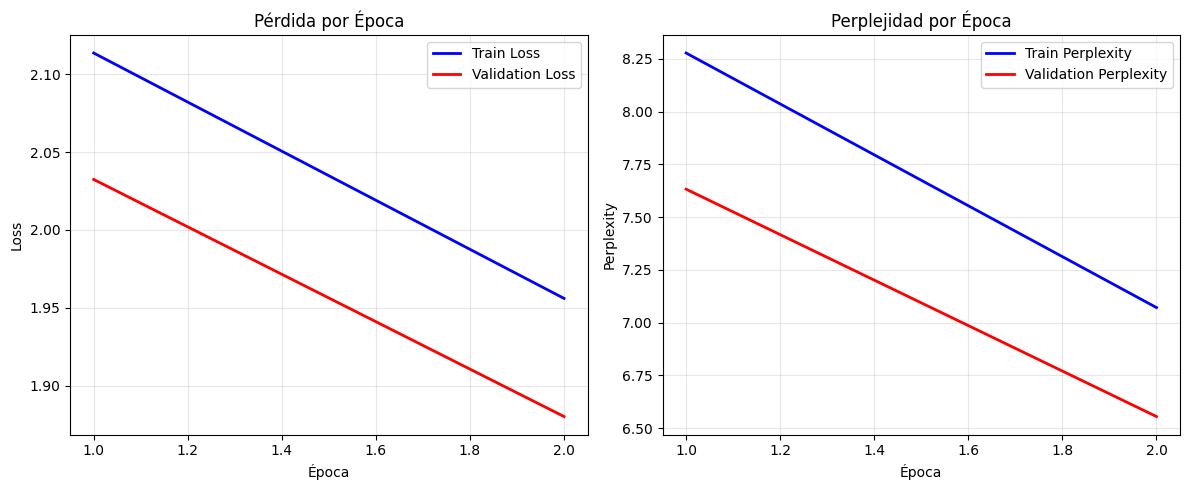

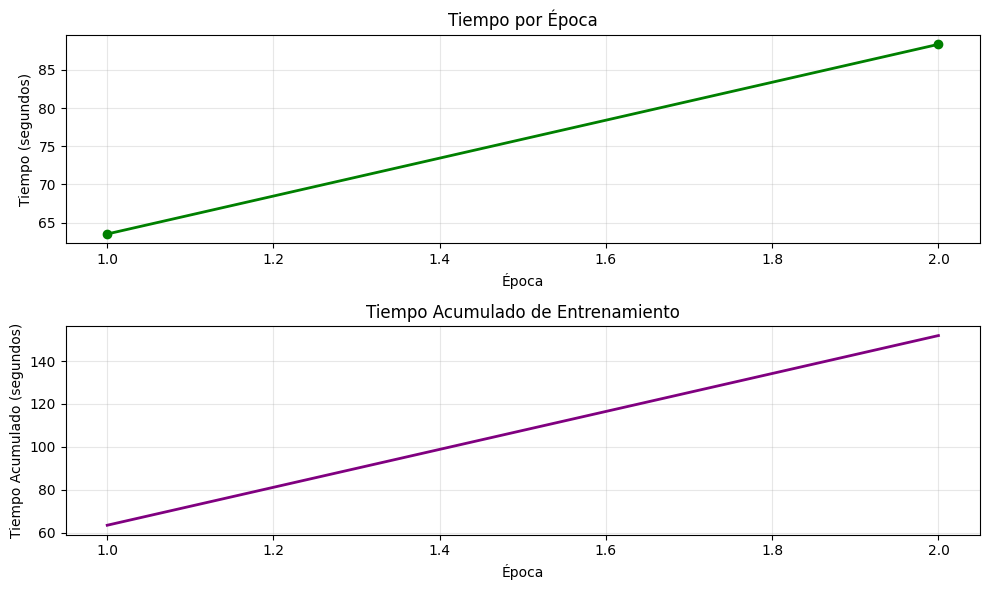


=== Resumen de Entrenamiento ===
Épocas totales: 2
Tiempo total: 151.88s (2.5 min)
Tiempo promedio por época: 75.94s
Loss final - Train: 1.9560, Val: 1.8802
Perplexity final - Train: 7.0712, Val: 6.5547


In [50]:
# Cargar y visualizar métricas
from metrics_logger import load_and_plot_metrics, compare_models_metrics

# Visualizar métricas de un modelo
metrics = load_and_plot_metrics("tinygpt_metrics.json", save_plots=True)

# Si tienes múltiples modelos para comparar:
# compare_models_metrics(
#     ["tinygpt_metrics.json", "tinygpt_moe_metrics.json"],
#     ["TinyGPT Base", "TinyGPT MoE"]
# )

#### Prueba rápida

In [51]:
generate(model=model, prompt="To be", max_new_tokens=100, use_cache=True) 

'To becoth wheratly\nNow creius dee they so, a be\nVOqer thou deveng that his\nthes, shout hi of thath forpr\n'

## Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

In [52]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    model: torch.nn.Module,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    do_sample: bool = True,
    device: torch.device = None
) -> str:
    """
    Función de generación mejorada con múltiples estrategias de decodificación.
    
    Args:
        model: Modelo TinyGPT entrenado
        prompt: Texto inicial para la generación
        max_new_tokens: Número máximo de tokens a generar
        use_cache: Si usar KV cache para acelerar la inferencia
        temperature: Temperatura para el muestreo (1.0 = sin cambios, <1 = más conservador, >1 = más aleatorio)
        top_k: Número de tokens top-k a considerar (0 = desactivado)
        top_p: Umbral de probabilidad acumulada para nucleus sampling (1.0 = desactivado)
        do_sample: Si usar muestreo (False = greedy decoding)
        device: Device donde ejecutar la inferencia
    
    Returns:
        Texto generado completo (prompt + tokens generados)
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None
    
    for _ in range(max_new_tokens):
        # Preparar input condicionado según si usamos cache
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]  # Solo el último token
        else:
            idx_cond = idx[:, -config.block_size:]  # Ventana completa
        
        # Forward pass
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        
        # Obtener logits del último token
        logits = logits[:, -1, :] / temperature  # Aplicar temperatura
        
        if do_sample:
            # === MUESTREO ===
            
            # Top-k filtering
            if top_k > 0:
                # Obtener los top-k logits más altos
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                # Crear máscara para filtrar el resto
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_logits)
                logits = logits_filtered
            
            # Top-p (nucleus) filtering
            if top_p < 1.0:
                # Ordenar logits de mayor a menor
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                # Calcular probabilidades acumuladas
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Crear máscara para tokens que exceden top_p
                sorted_indices_to_remove = cumulative_probs > top_p
                # Mantener al menos el primer token (el más probable)
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                
                # Aplicar máscara a logits ordenados
                sorted_logits[sorted_indices_to_remove] = float('-inf')
                # Reordenar de vuelta a posiciones originales
                logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(1))
            
            # Convertir a probabilidades y muestrear
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
        else:
            # === DECODIFICACIÓN GREEDY ===
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Concatenar el nuevo token
        idx = torch.cat((idx, next_token), dim=1)
    
    return decode(idx[0].tolist())


def top_k_top_p_filtering(logits: torch.Tensor, top_k: int = 0, top_p: float = 1.0) -> torch.Tensor:
    """
    Función auxiliar para filtrado top-k y top-p.
    """
    if top_k > 0:
        # Top-k filtering
        top_k = min(max(top_k, 1), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = float('-inf')

    if top_p < 1.0:
        # Top-p filtering
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # Scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = float('-inf')
    
    return logits


# Función de conveniencia para diferentes modos de generación
@torch.no_grad()
def generate_greedy(model, prompt: str, max_new_tokens: int = 100, **kwargs):
    """Generación greedy (determinística)"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        do_sample=False, 
        **kwargs
    )


@torch.no_grad()
def generate_with_temperature(model, prompt: str, temperature: float = 0.8, max_new_tokens: int = 100, **kwargs):
    """Generación con temperatura"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        temperature=temperature, 
        do_sample=True, 
        top_k=0, 
        top_p=1.0, 
        **kwargs
    )


@torch.no_grad()
def generate_top_k(model, prompt: str, top_k: int = 10, max_new_tokens: int = 100, **kwargs):
    """Generación con top-k sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=top_k, 
        top_p=1.0, 
        do_sample=True, 
        **kwargs
    )


@torch.no_grad()
def generate_nucleus(model, prompt: str, top_p: float = 0.9, max_new_tokens: int = 100, **kwargs):
    """Generación con nucleus (top-p) sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=0, 
        top_p=top_p, 
        do_sample=True, 
        **kwargs
    )

#### Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [53]:
# Comparar diferentes métodos de generación
prompt = "To be"

print("=== GENERACIÓN ORIGINAL ===")
result_original = generate(model=model, prompt=prompt, max_new_tokens=50, use_cache=True, device=device)
print(result_original)

print("\n=== DECODIFICACIÓN GREEDY ===")
result_greedy = generate_greedy(model, prompt, max_new_tokens=50, device=device)
print(result_greedy)

print("\n=== MUESTREO CON TEMPERATURA (0.5) ===")
result_temp_low = generate_with_temperature(model, prompt, temperature=0.5, max_new_tokens=50, device=device)
print(result_temp_low)

print("\n=== MUESTREO CON TEMPERATURA (1.5) ===")
result_temp_high = generate_with_temperature(model, prompt, temperature=1.5, max_new_tokens=50, device=device)
print(result_temp_high)

print("\n=== TOP-K SAMPLING (k=5) ===")
result_top_k = generate_top_k(model, prompt, top_k=5, max_new_tokens=50, device=device)
print(result_top_k)

print("\n=== NUCLEUS SAMPLING (p=0.9) ===")
result_nucleus = generate_nucleus(model, prompt, top_p=0.9, max_new_tokens=50, device=device)
print(result_nucleus)

print("\n=== COMBINADO: Top-k + Top-p + Temperatura ===")
result_combined = generateV2(
    model=model, 
    prompt=prompt, 
    max_new_tokens=50, 
    temperature=0.8, 
    top_k=10, 
    top_p=0.9, 
    device=device
)
print(result_combined)

=== GENERACIÓN ORIGINAL ===
To be freet what to herould o'd and of crition thus.

C

=== DECODIFICACIÓN GREEDY ===
To be the prown the the the powe the preat the preat th

=== MUESTREO CON TEMPERATURA (0.5) ===
To be cither ware be fring you, he be the do the to poo

=== MUESTREO CON TEMPERATURA (1.5) ===
To be.

CORIOLANCINIUS:
Thves witont.

VOr.

BRCGO!ROLA

=== TOP-K SAMPLING (k=5) ===
To be he mand and our mine that as softer,
I so cill we

=== NUCLEUS SAMPLING (p=0.9) ===
To beet whe promet.

MENENIUS:
The peat it bands horten

=== COMBINADO: Top-k + Top-p + Temperatura ===
To beare the make wish and a ded his the buch,
Than who


## Tarea II

- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [ ]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return None


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [19]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:


        return None

In [ ]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

#### Añadiendo MoE a la configuración

In [29]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

#### Entrenamiento de TinyGPT‑MoE

In [30]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [ ]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [ ]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

#### Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [31]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

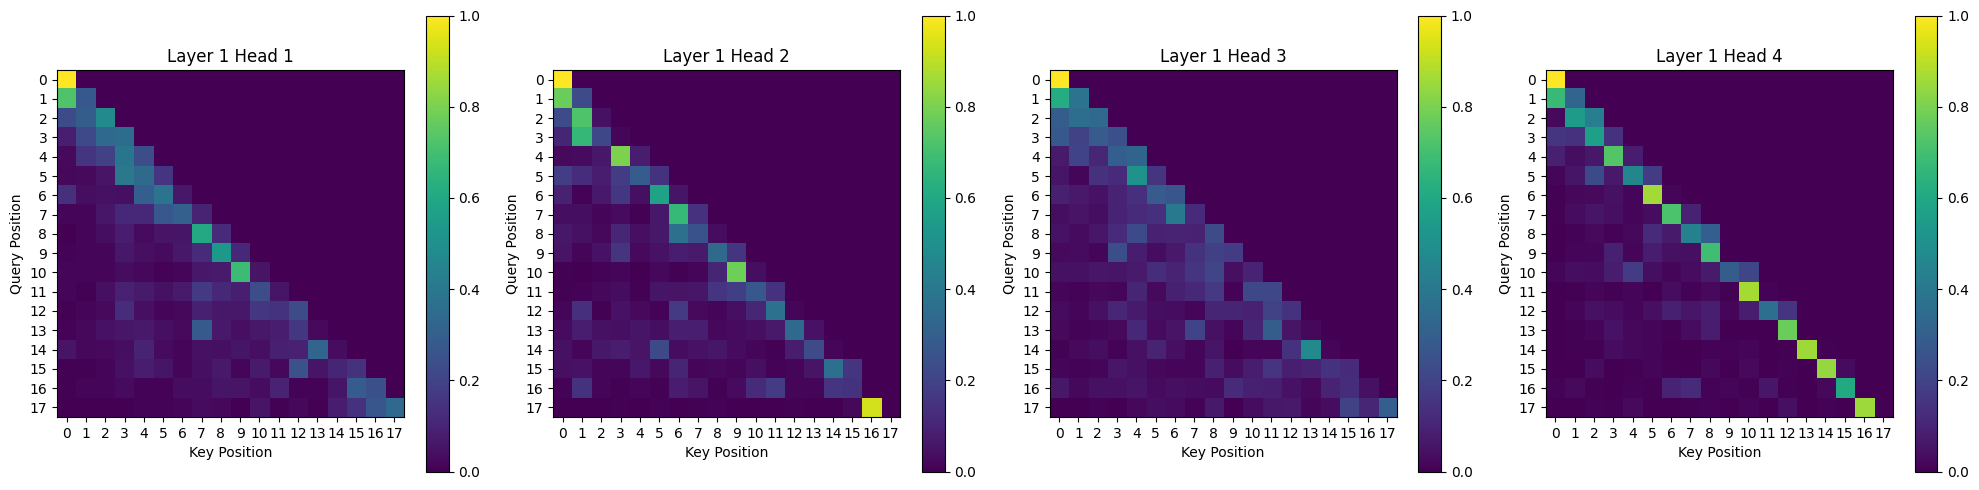

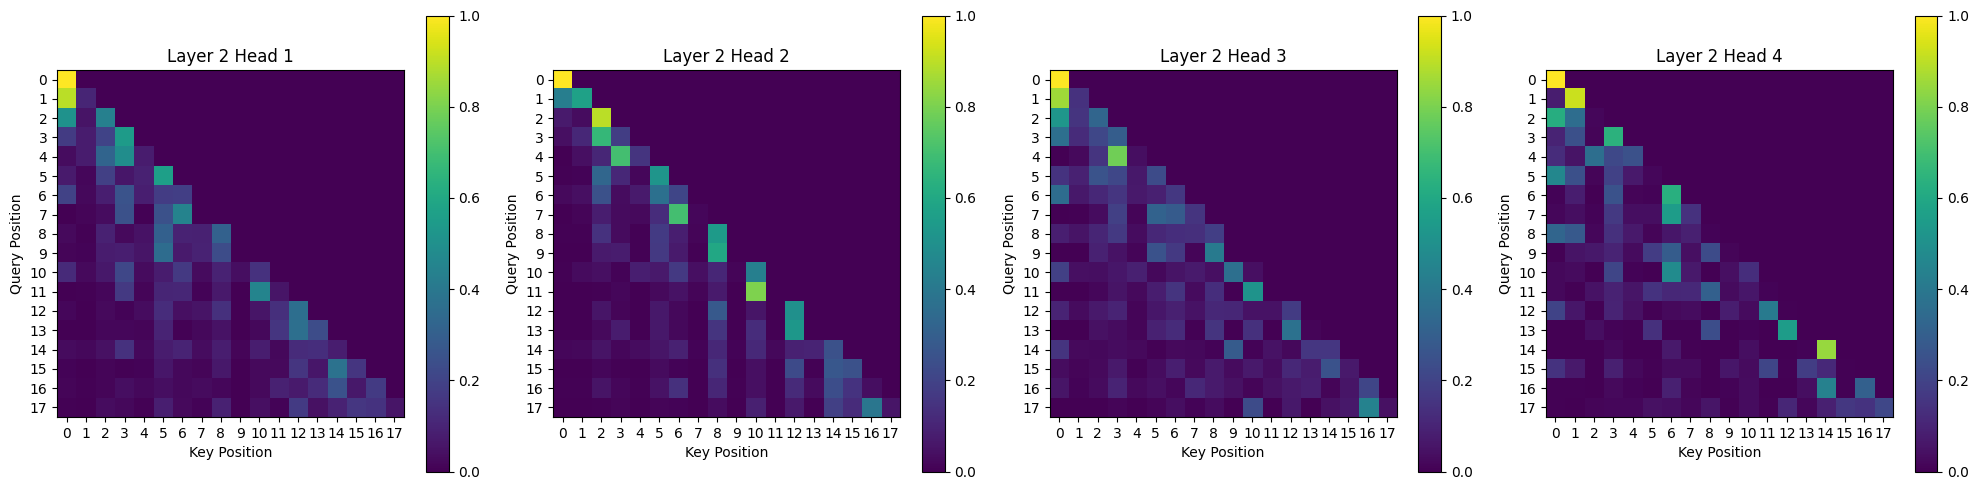

In [32]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

## Conclusiones